# Jane Street: Supervised Autoencoder MLP
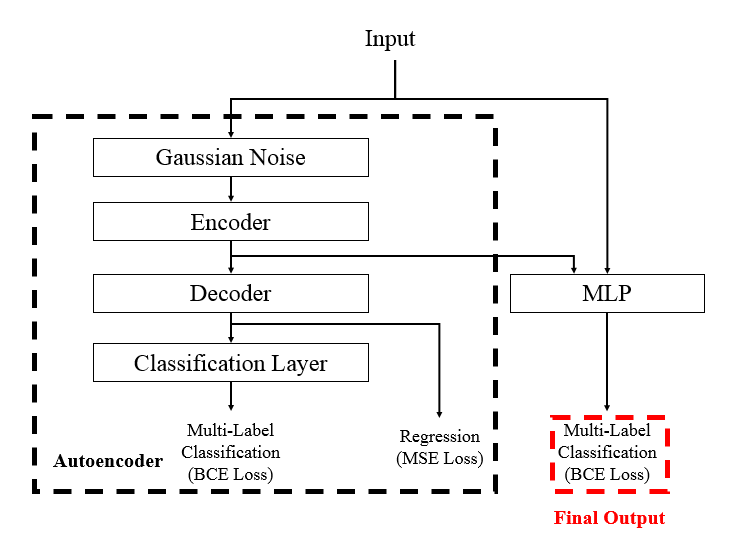

Reference:
[Bottleneck encoder + MLP + Keras Tuner 8601c5][1]

[1]: https://www.kaggle.com/aimind/bottleneck-encoder-mlp-keras-tuner-8601c5

In [71]:
import warnings
warnings.filterwarnings('ignore')
import os, gc
import pandas as pd
import numpy as np
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import dump, load
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from toad.metrics import AUC

In [20]:
train = pd.read_csv('credit.csv')
features = 23
X= train
Y= X.pop('default')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)

In [101]:
class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.mean()
        std = feature.std()
        return (feature - mean)/(std + 1e-6)    

In [109]:
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_features=[ 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [148]:
from tqdm.autonotebook import tqdm

feature_converters = {}
continuous_features_processed = []
continuous_features_processed_test = []

for f in tqdm(continuous_features):
    feature = X_train[f]
    feature_test = X_test[f]
    log = lambda x: np.log10(x + 1 - min(0, x.min()))
    converter = ContinuousFeatureConverter(f, feature, log)
    feature_converters[f] = converter
    continuous_features_processed.append(converter.transform(feature))
    continuous_features_processed_test.append(converter.transform(feature_test))
    
continuous_train = pd.DataFrame({s.name: s for s in continuous_features_processed}).astype(np.float32)
continuous_test = pd.DataFrame({s.name: s for s in continuous_features_processed_test}).astype(np.float32)
continuous_test.reset_index(inplace=True,drop=True)

  0%|          | 0/13 [00:00<?, ?it/s]

In [108]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm

def categorical_encode(df_train, df_test, categorical_features, n_values=140):
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
    
    categories = []
    #频率编码
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        df_test[column] = df_test[column].apply(lambda x: x if x in values2use else 'Other')
        
    #对频率编码后的结果进行onehot 本质上是减少了类别基数（把多余类别设为other）
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(pd.concat([df_train, df_test]))
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    df_test = pd.DataFrame(ohe.transform(df_test).toarray()).astype(np.float16)
    return df_train, df_test

In [149]:
train_categorical, test_categorical = categorical_encode(X_train, X_test, categorical_features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [150]:
trainx = pd.concat([continuous_train,train_categorical],axis=1)
testx = pd.concat([continuous_test,test_categorical],axis=1)

In [3]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls = 1e-2, lr = 1e-3):
    
    inp = tf.keras.layers.Input(shape = (num_columns, ))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'action')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = [decoder, out_ae, out])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                          'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls),
                          'action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls), 
                         },
                  metrics = {'decoder': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': tf.keras.metrics.AUC(name = 'AUC'), 
                             'action': tf.keras.metrics.AUC(name = 'AUC'), 
                            }, 
                 )
    
    return model

In [170]:
params = {'num_columns': 155, 
          'num_labels': 1, 
          'hidden_units': [128, 256, 256, 512, 128], 
          'dropout_rates': [0.25,0.3,0.25,0.3,0.25,0.3,0.25], 
          'ls': 0, 
          'lr':1e-3, 
         }

In [2]:
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

In [167]:
ckp_path = f'Model_{fold}.hdf5'
model = create_ae_mlp(**params)
ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'max')
es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
                           baseline = None, restore_best_weights = True, verbose = 0)
history = model.fit(trainx, [trainx, y_train, y_train], 
                        validation_data = (testx, [testx, y_test, y_test]),
                            epochs = 30, batch_size = batch_size, callbacks = [ckp, es], verbose = 1)
hist = pd.DataFrame(history.history)
score = hist['val_action_AUC'].max()
print(f'Fold {fold+1} ROC AUC:\t', score)
scores.append(score)
print('Weighted Average CV Score:', weighted_average(scores))

Epoch 1/30
282/282 [==============================] - 3s 5ms/step - loss: 1.2591 - decoder_loss: 0.2075 - ae_action_loss: 0.5352 - action_loss: 0.5164 - decoder_MAE: 0.3129 - ae_action_AUC: 0.6689 - action_AUC: 0.6821 - val_loss: 0.9480 - val_decoder_loss: 0.1115 - val_ae_action_loss: 0.4262 - val_action_loss: 0.4103 - val_decoder_MAE: 0.2013 - val_ae_action_AUC: 0.7872 - val_action_AUC: 0.7868
Epoch 2/30
282/282 [==============================] - 1s 4ms/step - loss: 1.0667 - decoder_loss: 0.1239 - ae_action_loss: 0.4745 - action_loss: 0.4682 - decoder_MAE: 0.2296 - ae_action_AUC: 0.7265 - action_AUC: 0.7380 - val_loss: 0.9192 - val_decoder_loss: 0.0928 - val_ae_action_loss: 0.4134 - val_action_loss: 0.4129 - val_decoder_MAE: 0.1820 - val_ae_action_AUC: 0.7824 - val_action_AUC: 0.7811
Epoch 3/30
282/282 [==============================] - 1s 4ms/step - loss: 1.0216 - decoder_loss: 0.0994 - ae_action_loss: 0.4651 - action_loss: 0.4571 - decoder_MAE: 0.1961 - ae_action_AUC: 0.7389 - actio

In [165]:
model.predict(X_test)[2].flatten()

array([0.04068986, 0.19667873, 0.6765232 , ..., 0.6672387 , 0.10541499,
       0.15781888], dtype=float32)

In [172]:
params = {'num_leaves': 88,
          'colsample_bytree': 0.75,
          'subsample': 0.75,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.45,
          'reg_lambda': 0.65,
          'random_state': 47,
          'n_jobs':-1,
          'n_estimators':10000,
         }

In [176]:
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)], \
                 eval_metric='auc', verbose=100, early_stopping_rounds=200)

[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.855208	valid_1's auc: 0.796404
[200]	training's auc: 0.891143	valid_1's auc: 0.795955
Early stopping, best iteration is:
[69]	training's auc: 0.843348	valid_1's auc: 0.79735


LGBMClassifier(bagging_seed=11, colsample_bytree=0.75, learning_rate=0.02,
               metric='auc', min_data_in_leaf=106, n_estimators=10000,
               num_leaves=88, objective='binary', random_state=47,
               reg_alpha=0.45, reg_lambda=0.65, subsample=0.75, verbosity=-1)